In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torch.optim.lr_scheduler import LambdaLR
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output

In [2]:
import optuna
import copy
from tqdm import tqdm
import shutil
import os
from datetime import datetime
# from torchsummary import summary

/Users/kkozik/Library/anaconda3/envs/torch_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
torch.manual_seed(42)

# Helper Functions

In [4]:
def remove_dataset_on_disk():
    if os.path.exists('./data'):
        shutil.rmtree('./data')
        print("Removing 'data' folder")
    else:
        print("'data' folder does not exists")

In [5]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [6]:
def plot_training_validation_loss(train_losses, val_losses):
    num_epochs = len(train_losses)

    plt.figure(figsize=(8, 6))
    plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss', marker='o')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', marker='o')
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.title('Training and Validation Loss', fontsize=16)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.show()

# Dataset Preparation and Augmentation

In [7]:
remove_dataset_on_disk()

Removing 'data' folder


In [8]:
# transform_train = transforms.Compose([
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomCrop(32, padding=4),
#     transforms.ToTensor(),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
# ])

# transform_test = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
# ])

def random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=1):
    def eraser(img):
        if np.random.rand() > p:
            return img
        img_h, img_w = img.shape[1:]
        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)
            if left + w <= img_w and top + h <= img_h:
                break
        c = np.random.uniform(v_l, v_h)
        img[:, top:top + h, left:left + w] = c
        return img
    return eraser

transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.Lambda(random_eraser(p=1))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [9]:
train_dataset_original = datasets.CIFAR10(root='./data', train=True, download=True, transform=None)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=None)

100%|██████████| 170498071/170498071 [00:07<00:00, 21454671.58it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [10]:
train_size = int(0.9 * len(train_dataset_original))
val_size = len(train_dataset_original) - train_size
train_dataset, val_dataset = random_split(train_dataset_original, [train_size, val_size])

In [11]:
train_dataset.dataset.transform = transform_train
val_dataset.dataset.transform = transform_test
test_dataset.transform = transform_test

# Model

In [12]:
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None, activation=nn.ReLU):
        super(ResBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.activation = activation()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.activation(out)
        out = self.conv2(out)
        out = self.bn1(out)

        if self.downsample:
            residual = self.downsample(x)

        out += residual
        out = self.activation(out)
        return out

class TransitionBlock(nn.Module):
    def __init__(self, in_channels, out_channels, activation=nn.ReLU):
        super(TransitionBlock, self).__init__()
        
        self.main_path = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1, bias=False),
            activation()
        )
        
        self.shortcut = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=2, bias=False),
            nn.BatchNorm2d(out_channels)
        )
        
    def forward(self, x):
        main_output = self.main_path(x)
        shortcut_output = self.shortcut(x)
        out = main_output + shortcut_output
        return out

class ResNet(nn.Module):
    def __init__(self, num_classes=10, input_shape=(32, 32, 3), size=44, starting_filter=16, activation=nn.ReLU, dropout_rate=0.0):
        super(ResNet, self).__init__()
        self.in_channels = starting_filter
        self.residual_blocks_num = (size - 2) // 6
        self.activation = activation
        self.dropout = nn.Dropout(dropout_rate)
        
        # Initial convolution layer
        self.conv1 = nn.Conv2d(input_shape[2], starting_filter, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(starting_filter)
        self.init_activation = activation()
        
        # Stacks of residual blocks with transition layers
        self.layer1 = self._make_layer(starting_filter, self.residual_blocks_num, stride=1, first_layer=True)
        self.transition1 = TransitionBlock(starting_filter, starting_filter * 2, activation)
        self.layer2 = self._make_layer(starting_filter * 2, self.residual_blocks_num, stride=1)
        self.transition2 = TransitionBlock(starting_filter * 2, starting_filter * 4, activation)
        self.layer3 = self._make_layer(starting_filter * 4, self.residual_blocks_num, stride=1)
        
        # Global average pooling and fully connected layer
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(starting_filter * 4, num_classes)

    def _make_layer(self, out_channels, blocks, stride=1, first_layer=False):
        layers = []
        if first_layer:
            layers.append(ResBlock(self.in_channels, out_channels, stride, activation=self.activation))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(ResBlock(out_channels, out_channels, activation=self.activation))
        return nn.Sequential(*layers)

    def forward(self, x):
        # Initial convolution layer
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.init_activation(x)
        
        # ResNet blocks with transitions
        x = self.layer1(x)
        x = self.transition1(x)
        x = self.layer2(x)
        x = self.transition2(x)
        x = self.layer3(x)
        
        # Global average pooling and output
        x = self.avg_pool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)
        
        return x

In [13]:
model = ResNet(activation=nn.ELU, dropout_rate=0.5)
model

ResNet(
  (dropout): Dropout(p=0.5, inplace=False)
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (init_activation): ELU(alpha=1.0)
  (layer1): Sequential(
    (0): ResBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (activation): ELU(alpha=1.0)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (activation): ELU(alpha=1.0)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): ResBlock(
      (conv1): 

In [14]:
print(f"Total parameters: {count_parameters(model):,}")

Total parameters: 613,498


In [15]:
def init_weights(m):
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

In [16]:
device = torch.device("mps")
model.to(device)
model.apply(init_weights)
clear_output()

In [17]:
learning_rate = 0.1
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.001)
scheduler = LambdaLR(optimizer, lr_lambda=lambda epoch: 0.1 if epoch > 5 and epoch <= 10 else 0.01 if epoch > 10 else 1.0)

criterion = nn.CrossEntropyLoss()

In [18]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [19]:
max_epochs = 30
early_stopping_patience = 5
best_val_loss = np.inf
steps_without_improvement = 0
train_losses, val_losses = [], []

for epoch in range(max_epochs):
    print(f"Epoch {epoch+1}/{max_epochs}")

    # Training
    model.train()
    running_loss = 0.0
    for inputs, labels in tqdm(train_loader, desc="Training Batches"):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for val_inputs, val_labels in tqdm(val_loader, desc="Validation Batches"):
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            val_outputs = model(val_inputs)
            val_loss += criterion(val_outputs, val_labels).item() * val_inputs.size(0)

    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)
    print(f"Training Loss: {epoch_loss:.4f}, Validation Loss: {val_loss:.4f}")

    # Early Stopping
    if val_loss < best_val_loss:
        steps_without_improvement = 0
        best_val_loss = val_loss
        best_model = copy.deepcopy(model)
    else:
        steps_without_improvement += 1
        print(f"Epoch {epoch+1} wasn't better than the previous")
    
    if steps_without_improvement >= early_stopping_patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

    scheduler.step()

Epoch 1/30


Validation Batches: 100%|██████████| 40/40 [00:01<00:00, 33.28it/s]


Training Loss: 1.8648, Validation Loss: 1.8590
Epoch 2/30


Validation Batches: 100%|██████████| 40/40 [00:01<00:00, 37.43it/s]


Training Loss: 1.4911, Validation Loss: 1.4997
Epoch 3/30


Validation Batches: 100%|██████████| 40/40 [00:01<00:00, 40.00it/s]


Training Loss: 1.2643, Validation Loss: 1.2054
Epoch 4/30


Validation Batches: 100%|██████████| 40/40 [00:01<00:00, 38.95it/s]


Training Loss: 1.1039, Validation Loss: 1.1377
Epoch 5/30


Validation Batches: 100%|██████████| 40/40 [00:01<00:00, 38.21it/s]


Training Loss: 0.9880, Validation Loss: 1.0560
Epoch 6/30


Validation Batches: 100%|██████████| 40/40 [00:01<00:00, 39.27it/s]


Training Loss: 0.9064, Validation Loss: 1.0425
Epoch 7/30


Validation Batches: 100%|██████████| 40/40 [00:01<00:00, 39.02it/s]


Training Loss: 0.6524, Validation Loss: 0.6021
Epoch 8/30


Validation Batches: 100%|██████████| 40/40 [00:01<00:00, 38.99it/s]


Training Loss: 0.5760, Validation Loss: 0.5866
Epoch 9/30


Validation Batches: 100%|██████████| 40/40 [00:01<00:00, 38.24it/s]


Training Loss: 0.5395, Validation Loss: 0.5531
Epoch 10/30


Validation Batches: 100%|██████████| 40/40 [00:01<00:00, 38.29it/s]


Training Loss: 0.5105, Validation Loss: 0.5975
Epoch 10 wasn't better than the previous
Epoch 11/30


Validation Batches: 100%|██████████| 40/40 [00:01<00:00, 37.69it/s]


Training Loss: 0.4855, Validation Loss: 0.6048
Epoch 11 wasn't better than the previous
Epoch 12/30


Validation Batches: 100%|██████████| 40/40 [00:01<00:00, 37.63it/s]


Training Loss: 0.4100, Validation Loss: 0.4945
Epoch 13/30


Validation Batches: 100%|██████████| 40/40 [00:01<00:00, 37.67it/s]


Training Loss: 0.3885, Validation Loss: 0.4943
Epoch 14/30


Validation Batches: 100%|██████████| 40/40 [00:01<00:00, 38.65it/s]


Training Loss: 0.3770, Validation Loss: 0.4910
Epoch 15/30


Validation Batches: 100%|██████████| 40/40 [00:01<00:00, 39.43it/s]


Training Loss: 0.3691, Validation Loss: 0.4899
Epoch 16/30


Validation Batches: 100%|██████████| 40/40 [00:01<00:00, 39.09it/s]


Training Loss: 0.3603, Validation Loss: 0.4903
Epoch 16 wasn't better than the previous
Epoch 17/30


Validation Batches: 100%|██████████| 40/40 [00:01<00:00, 38.13it/s]


Training Loss: 0.3545, Validation Loss: 0.4873
Epoch 18/30


Validation Batches: 100%|██████████| 40/40 [00:01<00:00, 38.74it/s]


Training Loss: 0.3482, Validation Loss: 0.4940
Epoch 18 wasn't better than the previous
Epoch 19/30


Validation Batches: 100%|██████████| 40/40 [00:01<00:00, 36.23it/s]


Training Loss: 0.3407, Validation Loss: 0.4925
Epoch 19 wasn't better than the previous
Epoch 20/30


Validation Batches: 100%|██████████| 40/40 [00:01<00:00, 38.74it/s]


Training Loss: 0.3341, Validation Loss: 0.4936
Epoch 20 wasn't better than the previous
Epoch 21/30


Validation Batches: 100%|██████████| 40/40 [00:01<00:00, 39.39it/s]


Training Loss: 0.3266, Validation Loss: 0.4919
Epoch 21 wasn't better than the previous
Epoch 22/30


Validation Batches: 100%|██████████| 40/40 [00:01<00:00, 39.37it/s]

Training Loss: 0.3196, Validation Loss: 0.4908
Epoch 22 wasn't better than the previous
Early stopping at epoch 22


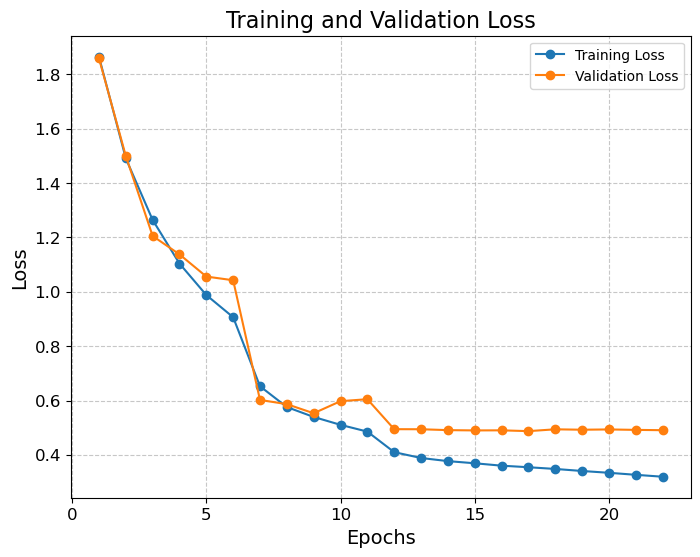

In [20]:
plot_training_validation_loss(train_losses, val_losses)

In [21]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for test_inputs, test_labels in test_loader:
        test_inputs, test_labels = test_inputs.to(device), test_labels.to(device)
        outputs = model(test_inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += test_labels.size(0)
        correct += (predicted == test_labels).sum().item()

test_accuracy = correct / total
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

Test Accuracy: 82.52%


# Hyperparameters Optimization

In [24]:
def objective(trial):
    # Save logs
    log_file = 'optimization_log_resnet.txt'
    
    # Hyperparameters
    activation = trial.suggest_categorical("activation", [nn.ReLU, nn.ELU])
    optimizer_name = trial.suggest_categorical("optimizer", ["SGD", "Adam"])
    lr = trial.suggest_uniform("lr", 0.05, 0.15)
    weight_decay = trial.suggest_loguniform("weight_decay", 1e-6, 1e-2)
    # batch_size = trial.suggest_categorical("batch_size", [128, 256])
    batch_size = trial.suggest_categorical("batch_size", [128])
    dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)

    # Scheduler learning rates
    lr1 = trial.suggest_loguniform("scheduler_lr1", 0.8, 1.0)
    lr2 = trial.suggest_loguniform("scheduler_lr2", 0.08, 0.1)
    lr3 = trial.suggest_loguniform("scheduler_lr3", 0.008, 0.01)
    lr4 = trial.suggest_loguniform("scheduler_lr4", 0.006, 0.008)

    # Scheduler epochs
    scheduler_epoch1 = trial.suggest_int("scheduler_epoch1", 3, 15)
    scheduler_epoch2 = trial.suggest_int("scheduler_epoch2", scheduler_epoch1 + 1, 25)
    scheduler_epoch3 = trial.suggest_int("scheduler_epoch3", scheduler_epoch2 + 1, 35)

    # Dataloaders with tuned batch_size
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    # Model
    model = ResNet(num_classes=10, activation=activation, dropout_rate=dropout_rate)
    model.apply(init_weights)
    device = torch.device("mps")
    model.to(device)
    
    # Optimizer
    if optimizer_name == "SGD":
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay)
    else:
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    # Scheduler
    scheduler = LambdaLR(
        optimizer,
        lr_lambda=lambda epoch: lr1 if epoch < scheduler_epoch1 else lr2 if epoch < scheduler_epoch2 else lr3 if epoch < scheduler_epoch3 else lr4
        )

    # Loss function
    criterion = nn.CrossEntropyLoss()

    with open(log_file, 'a') as f:
        f.write(f"\n\n--- New Trial ---\n")
        f.write(f"Trial {trial.number} - {datetime.now()}\n")
        f.write(f"Hyperparameters: activation={activation}, optimizer={optimizer_name}, lr={lr}, "
                f"weight_decay={weight_decay}, batch_size={batch_size}, "
                f"scheduler_lr1={lr1}, scheduler_lr2={lr2}, scheduler_lr3={lr3}, scheduler_lr4={lr4}, "
                f"scheduler_epoch1={scheduler_epoch1}, scheduler_epoch2={scheduler_epoch2}, , scheduler_epoch3={scheduler_epoch3}\n"
                )

    # Training and validation
    max_epochs = 40
    early_stopping_patience = 8
    best_val_loss = np.inf
    steps_without_improvement = 0

    for epoch in range(max_epochs):
        epoch_start_time = datetime.now()
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)

        train_loss = running_loss / len(train_loader.dataset)

        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for val_inputs, val_labels in val_loader:
                val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
                val_outputs = model(val_inputs)
                loss = criterion(val_outputs, val_labels)
                val_loss += loss.item() * val_inputs.size(0)
                _, predicted = torch.max(val_outputs.data, 1)
                total += val_labels.size(0)
                correct += (predicted == val_labels).sum().item()

        val_loss /= len(val_loader.dataset)
        val_accuracy = correct / total

        with open(log_file, 'a') as f:
            f.write(f"Epoch {epoch+1}/{max_epochs} - {epoch_start_time}\n"
                    f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
                    f"Val Accuracy: {val_accuracy:.4f}\n")

        # Early stopping
        if val_loss < best_val_loss:
            steps_without_improvement = 0
            best_val_loss = val_loss
        else:
            steps_without_improvement += 1
        
        if steps_without_improvement >= early_stopping_patience:
            with open(log_file, 'a') as f:
                f.write(f"Early stopping at epoch {epoch+1}\n")
            break

        # Scheduler step
        scheduler.step()

        # Optuna report
        trial.report(val_accuracy, epoch)

        # Pruning
        if trial.should_prune():
            with open(log_file, 'a') as f:
                f.write(f"Trial {trial.number} pruned at epoch {epoch+1}\n")
            raise optuna.exceptions.TrialPruned()

    # Evaluation on the test set
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for test_inputs, test_labels in test_loader:
            test_inputs, test_labels = test_inputs.to(device), test_labels.to(device)
            outputs = model(test_inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += test_labels.size(0)
            correct += (predicted == test_labels).sum().item()
    test_accuracy = correct / total

    with open(log_file, 'a') as f:
        f.write(f"Final Test Accuracy: {test_accuracy:.4f} - {datetime.now()}\n")

    return test_accuracy

In [25]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

[I 2024-10-29 22:56:56,861] A new study created in memory with name: no-name-abd98e7e-9d18-432e-a139-294eb5ae5fca
/var/folders/bl/szgb52vx4p19h00643wv96mh0000gn/T/ipykernel_31452/3988544656.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  lr = trial.suggest_uniform("lr", 0.05, 0.15)
/var/folders/bl/szgb52vx4p19h00643wv96mh0000gn/T/ipykernel_31452/3988544656.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-6, 1e-2)
/var/folders/bl/szgb52vx4p19h00643wv96mh0000gn/T/ipykernel_31452/3988544656.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optu

In [26]:
print("Best trial:")
trial = study.best_trial
print(f"Test Accuracy: {trial.value:.4f}")

Best trial:
Test Accuracy: 0.8426


In [27]:
print("Best hyperparameters:")
for key, value in trial.params.items():
    print(f"  - {key}: {value}")

Best hyperparameters:
  - activation: <class 'torch.nn.modules.activation.ELU'>
  - optimizer: SGD
  - lr: 0.05515952011638349
  - weight_decay: 1.9379324994425267e-05
  - batch_size: 128
  - dropout_rate: 0.27443045263423627
  - scheduler_lr1: 0.8203865395871073
  - scheduler_lr2: 0.0954526458038401
  - scheduler_lr3: 0.009972843471204789
  - scheduler_lr4: 0.006503556260637943
  - scheduler_epoch1: 11
  - scheduler_epoch2: 13
  - scheduler_epoch3: 22


# Best model

In [28]:
# Best model params
best_params = trial.params

# Hyperparameters
activation = best_params["activation"]
optimizer_name = best_params["optimizer"]
lr = best_params["lr"]
weight_decay = best_params["weight_decay"]
batch_size = best_params["batch_size"]
dropout_rate = best_params["dropout_rate"]
scheduler_lr1 = best_params["scheduler_lr1"]
scheduler_lr2 = best_params["scheduler_lr2"]
scheduler_lr3 = best_params["scheduler_lr3"]
scheduler_epoch1 = best_params["scheduler_epoch1"]
scheduler_epoch2 = best_params["scheduler_epoch2"]

# Model
model = ResNet(num_classes=10, activation=activation, dropout_rate=dropout_rate)
model.apply(init_weights)
device = torch.device("mps")
model.to(device)

# Optimizer
if optimizer_name == "SGD":
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay)
else:
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

scheduler = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lr_lambda=lambda epoch: scheduler_lr1 if epoch < scheduler_epoch1 
    else scheduler_lr2 if epoch < scheduler_epoch2 
    else scheduler_lr3
)

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Loss function
criterion = nn.CrossEntropyLoss()

# Training
max_epochs = 40
early_stopping_patience = 8
best_val_loss = float("inf")
steps_without_improvement = 0
best_model_state = None

for epoch in range(max_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{max_epochs}"):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)

    train_loss = running_loss / len(train_loader.dataset)

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for val_inputs, val_labels in val_loader:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            val_outputs = model(val_inputs)
            loss = criterion(val_outputs, val_labels)
            val_loss += loss.item() * val_inputs.size(0)
            _, predicted = torch.max(val_outputs.data, 1)
            total += val_labels.size(0)
            correct += (predicted == val_labels).sum().item()

    val_loss /= len(val_loader.dataset)
    val_accuracy = correct / total

    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        steps_without_improvement = 0
        best_model_state = model.state_dict()
    else:
        steps_without_improvement += 1
        if steps_without_improvement >= early_stopping_patience:
            print("Early stopping")
            break

    scheduler.step()

Epoch 1/40: 100%|██████████| 352/352 [00:20<00:00, 17.19it/s]


Epoch 1, Train Loss: 1.5261, Val Loss: 1.3120, Val Accuracy: 0.5262


Epoch 2/40: 100%|██████████| 352/352 [00:20<00:00, 17.53it/s]


Epoch 2, Train Loss: 1.0325, Val Loss: 1.0293, Val Accuracy: 0.6390


Epoch 3/40: 100%|██████████| 352/352 [00:20<00:00, 17.26it/s]


Epoch 3, Train Loss: 0.8473, Val Loss: 0.9324, Val Accuracy: 0.6822


Epoch 4/40: 100%|██████████| 352/352 [00:20<00:00, 17.57it/s]


Epoch 4, Train Loss: 0.7236, Val Loss: 0.8100, Val Accuracy: 0.7180


Epoch 5/40: 100%|██████████| 352/352 [00:19<00:00, 17.69it/s]


Epoch 5, Train Loss: 0.6354, Val Loss: 0.8018, Val Accuracy: 0.7268


Epoch 6/40: 100%|██████████| 352/352 [00:19<00:00, 17.65it/s]


Epoch 6, Train Loss: 0.5696, Val Loss: 0.7122, Val Accuracy: 0.7534


Epoch 7/40: 100%|██████████| 352/352 [00:19<00:00, 17.66it/s]


Epoch 7, Train Loss: 0.5040, Val Loss: 0.6462, Val Accuracy: 0.7782


Epoch 8/40: 100%|██████████| 352/352 [00:19<00:00, 17.67it/s]


Epoch 8, Train Loss: 0.4545, Val Loss: 0.7789, Val Accuracy: 0.7410


Epoch 9/40: 100%|██████████| 352/352 [00:20<00:00, 17.53it/s]


Epoch 9, Train Loss: 0.4038, Val Loss: 0.6974, Val Accuracy: 0.7730


Epoch 10/40: 100%|██████████| 352/352 [00:19<00:00, 17.67it/s]


Epoch 10, Train Loss: 0.3576, Val Loss: 0.6634, Val Accuracy: 0.7762


Epoch 11/40: 100%|██████████| 352/352 [00:19<00:00, 17.68it/s]


Epoch 11, Train Loss: 0.3200, Val Loss: 0.6477, Val Accuracy: 0.7968


Epoch 12/40: 100%|██████████| 352/352 [00:20<00:00, 17.33it/s]


Epoch 12, Train Loss: 0.1650, Val Loss: 0.5458, Val Accuracy: 0.8228


Epoch 13/40: 100%|██████████| 352/352 [00:20<00:00, 17.45it/s]


Epoch 13, Train Loss: 0.1126, Val Loss: 0.5759, Val Accuracy: 0.8248


Epoch 14/40: 100%|██████████| 352/352 [00:20<00:00, 17.26it/s]


Epoch 14, Train Loss: 0.0879, Val Loss: 0.5730, Val Accuracy: 0.8234


Epoch 15/40: 100%|██████████| 352/352 [00:19<00:00, 17.61it/s]


Epoch 15, Train Loss: 0.0842, Val Loss: 0.5777, Val Accuracy: 0.8224


Epoch 16/40: 100%|██████████| 352/352 [00:19<00:00, 17.68it/s]


Epoch 16, Train Loss: 0.0828, Val Loss: 0.5800, Val Accuracy: 0.8238


Epoch 17/40: 100%|██████████| 352/352 [00:20<00:00, 17.45it/s]


Epoch 17, Train Loss: 0.0796, Val Loss: 0.5823, Val Accuracy: 0.8218


Epoch 18/40: 100%|██████████| 352/352 [00:20<00:00, 17.33it/s]


Epoch 18, Train Loss: 0.0772, Val Loss: 0.5871, Val Accuracy: 0.8224


Epoch 19/40: 100%|██████████| 352/352 [00:20<00:00, 16.93it/s]


Epoch 19, Train Loss: 0.0760, Val Loss: 0.5908, Val Accuracy: 0.8210


Epoch 20/40: 100%|██████████| 352/352 [00:20<00:00, 17.49it/s]


Epoch 20, Train Loss: 0.0733, Val Loss: 0.5934, Val Accuracy: 0.8216
Early stopping


In [29]:
classes = test_dataset.classes

In [30]:
def show_predictions(img, true_labels, predicted_labels, batch_size):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.figure(figsize=(batch_size * 2, 2))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    
    for i in range(len(true_labels)):
        label_text = f"True: {classes[true_labels[i]]}\nPred: {classes[predicted_labels[i]]}"
        plt.text(i * (npimg.shape[2] / len(true_labels)) + (npimg.shape[2] / (2 * len(true_labels))),
                 -2,
                 label_text,
                 ha='center',
                 va='bottom',
                 fontsize=12,
                 color='white',
                 bbox=dict(facecolor='black', alpha=0.5, edgecolor='none'))
    
    plt.show()

In [41]:
def display_predictions(model, test_loader, classes, num_images=8, num_sample_rows=3):
    dataiter = iter(test_loader)
    for _ in range(num_sample_rows):
        images, labels = next(dataiter)
        images, labels = images[:num_images], labels[:num_images]
        images, labels = images.to(device), labels.to(device)

        model.eval()
        with torch.no_grad():
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

        images = images.cpu()
        labels = labels.cpu()
        predicted = predicted.cpu()

        show_predictions(torchvision.utils.make_grid(images), labels, predicted, num_images)
        for i in range(len(labels)):
            print(f"True label: {classes[labels[i]]}, Predicted: {classes[predicted[i]]}")

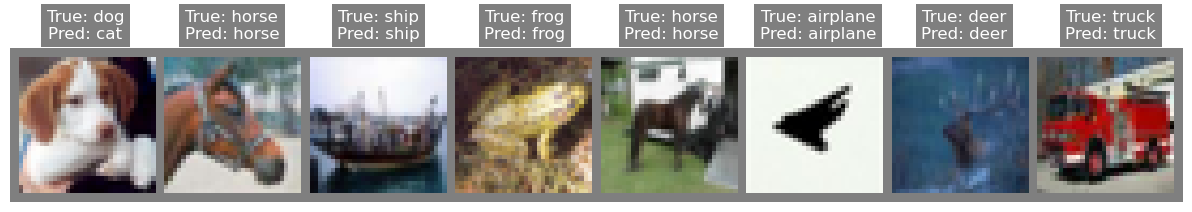

True label: dog, Predicted: cat
True label: horse, Predicted: horse
True label: ship, Predicted: ship
True label: frog, Predicted: frog
True label: horse, Predicted: horse
True label: airplane, Predicted: airplane
True label: deer, Predicted: deer
True label: truck, Predicted: truck


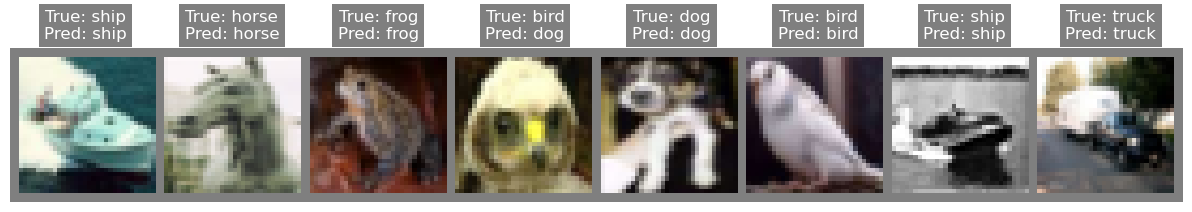

True label: ship, Predicted: ship
True label: horse, Predicted: horse
True label: frog, Predicted: frog
True label: bird, Predicted: dog
True label: dog, Predicted: dog
True label: bird, Predicted: bird
True label: ship, Predicted: ship
True label: truck, Predicted: truck


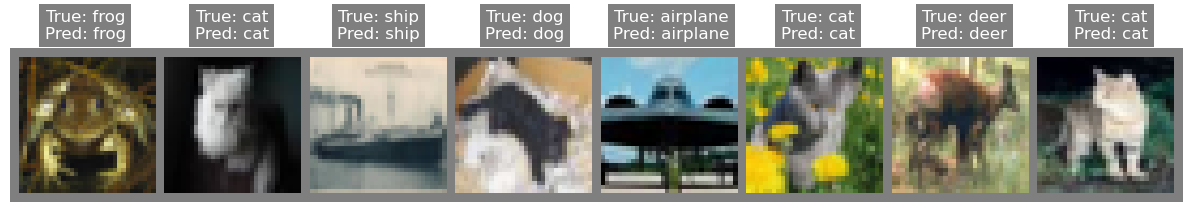

True label: frog, Predicted: frog
True label: cat, Predicted: cat
True label: ship, Predicted: ship
True label: dog, Predicted: dog
True label: airplane, Predicted: airplane
True label: cat, Predicted: cat
True label: deer, Predicted: deer
True label: cat, Predicted: cat


In [42]:
display_predictions(model, test_loader, classes)

In [52]:
remove_dataset_on_disk()

Removing 'data' folder
